In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

from thesis.utils.metrics import *

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
import sys
print sys.executable

/home/stud/shalaby/.virtualenv/thesis-env/bin/python2


In [3]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [4]:
IS_SAMPLE = False

In [5]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234

In [6]:
NUMBER_INDICATOR = "number_inidicator"
CURRENCY_INDICATOR = "currency_inidicator"
CHEMICAL_INDICATOR = "chemical_inidicator"
MIN_WORD_COUNT = 100 # Suggested by Levy and goldberg
MIN_SIZE = 0
NUM_CORES = 16

In [7]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [8]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"

In [9]:
#training_file = "/home/local/shalaby/docs_output_sample_100.json"

root_location = "/mnt/data2/shalaby/"
exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(root_location, "parameter_search_doc2vec_models_new", "full")
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

training_file = root_location + "docs_output.json"

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
training_docs_list_file = exports_location + "training_docs_list.pkl"
validation_docs_list_file = exports_location + "validation_docs_list.pkl"
test_docs_list_file = exports_location + "test_docs_list.pkl"

preprocessed_location = root_location + "preprocessed_data/"

training_preprocessed_files_prefix = preprocessed_location + "training_docs_merged_data_preprocessed-"
training_preprocessed_docids_files_prefix = preprocessed_location + "training_docs_merged_docids_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "validation_docs_merged_data_preprocessed-"
validation_preprocessed_docids_files_prefix = preprocessed_location + "validation_docs_merged_docids_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
#test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 16.5 s, sys: 628 ms, total: 17.1 s
Wall time: 17.1 s


In [11]:
len(training_docs_list)

1286325

In [12]:
len(validation_docs_list)

321473

In [13]:
def stemtokenizer(text):
    """ MAIN FUNCTION to get clean stems out of a text. A list of clean stems are returned """
    tokenizer = RegexpTokenizer(r'\s+', gaps=True)
    tokens = tokenizer.tokenize(text)
    stems = []  # result
    for token in tokens:
        stem = token.lower()
        stem = stem.strip(string.punctuation)
        if stem:
            if is_number(stem):
                stem = NUMBER_INDICATOR
            elif is_currency(stem):
                stem = CURRENCY_INDICATOR
            elif is_chemical(stem):
                stem = CHEMICAL_INDICATOR
            else:
                stem = stem.strip(string.punctuation)
            if stem and len(stem) >= MIN_SIZE:
                # extract uni-grams
                stems.append(stem)
    del tokens
    return stems

def is_number(str):
    """ Returns true if given string is a number (float or int)"""
    try:
        float(str.replace(",", ""))
        return True
    except ValueError:
        return False

def is_currency(str):
    return str[0] == "$"

def is_chemical(str):
    return str.count("-") > 3

In [14]:
def ensure_hdfs_location_exists(location):
    parent = os.path.dirname(location)
    os.system("hdfs dfs -mkdir -p " + location)

def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [15]:
def get_validation_docs_with_inference(doc2vec_model, doc_classification_map):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # do inference and store results in dict
        i = 0
        for (doc_id, doc_contents_array) in ValidationDocumentGenerator(training_file, validation_docs_list):
            i += 1
            if i % 1000 == 0: info("Finished: {}".format(str(i)))
            validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)

        # create matrix for the validation vectors
        for validation_doc_id in validation_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            validation_labels.append([classf for classf in doc_classification_map[validation_doc_id] if classf in sections])
        validation_vectors_matrix = np.array(validation_vectors)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix

In [16]:
def get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                           val_docs_list, val_preprocessed_files_prefix, val_preprocessed_docids_files_prefix):
    """
    Use the trained doc2vec model to get the paragraph vector representations of the validation documents
    """

    def infer_one_doc(doc_tuple):
        #doc2vec_model.random = np.random.RandomState(DOC2VEC_SEED)
        doc_id, doc_tokens = doc_tuple
        rep = doc2vec_model.infer_vector(doc_tokens)
        return (doc_id, rep)

    one_hot_encoder = OneHotEncoder(classifications)
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)):
        info("===== Loading validation vectors")
        validation_labels = []
        validation_vectors_matrix = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX)))
        for validation_doc_id in val_docs_list:
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_labels = np.array(validation_labels)
    else:
        validation_documents_reps = {}
        validation_vectors = []
        validation_labels = []
        info("===== Getting validation vectors with inference")

        # Single-threaded inference
        # do inference and store results in dict
#         i = 0
        
#         validation_docs_iterator = DocumentBatchGenerator(val_preprocessed_files_prefix, 
#                                                         val_preprocessed_docids_files_prefix, batch_size=None)
#         for (doc_id, doc_contents_array) in validation_docs_iterator:
#             i += 1
#             if i % 1000 == 0: info("Finished: {}".format(str(i)))
#             validation_documents_reps[doc_id] = doc2vec_model.infer_vector(doc_contents_array)
        
        # Multi-threaded inference
        validation_docs_iterator = DocumentBatchGenerator(validation_preprocessed_files_prefix, 
                                                          validation_preprocessed_docids_files_prefix, batch_size=None)
        generator_func = validation_docs_iterator.__iter__()
        pool = ThreadPool(NUM_CORES)
        # map consumes the whole iterator on the spot, so we have to use itertools.islice to fake mini-batching
        validation_documents_reps = {}
        mini_batch_size = 1000
        while True:
            threaded_reps_partial = pool.map(infer_one_doc, itertools.islice(generator_func, mini_batch_size))
            info("Finished: {}".format(str(validation_docs_iterator.curr_index)))
            if threaded_reps_partial:
                #threaded_reps.extend(threaded_reps_partial)
                validation_documents_reps.update(threaded_reps_partial)
            else:
                break

                
        # create matrix for the validation vectors
        for validation_doc_id in val_docs_list:
            validation_vectors.append(validation_documents_reps[validation_doc_id])
            val_labels = [classf for classf in doc_classification_map[validation_doc_id] if classf in classifications]
            validation_labels.append(one_hot_encoder.get_label_vector(val_labels))
        validation_vectors_matrix = np.array(validation_vectors)
        validation_labels = np.array(validation_labels)
        pickle.dump(validation_vectors_matrix, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_MATRIX), 'w'))
    
    return validation_vectors_matrix, validation_labels

In [17]:
def get_validation_doc2vec_spark_vectors(validation_vectors_matrix, classification, doc_classification_map):
    validation_vectors = []
    for (index, doc_id) in enumerate(validation_docs_list):
        # converting from memmap to a normal array as spark is unable to convert memmap to a spark Vector
        validation_vector = validation_vectors_matrix[index]
        validation_vectors.append(get_training_vector(classification, validation_vector, 
                                                    doc_classification_map[doc_id]))
    validation_vectors = sc.parallelize(validation_vectors)
    info("Finished getting validation vectors")
    return validation_vectors

In [18]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector

def get_training_data(doc2vec_model, classifications):
    one_hot_encoder = OneHotEncoder(classifications)
    training_data = []
    training_labels = []
    for doc_id in training_docs_list:
        # converting from memmap to a normal array
        normal_array = []
        normal_array[:] = doc2vec_model.docvecs[doc_id][:]
        training_data.append(normal_array)
        eligible_classifications = [clssf for clssf in doc_classification_map[doc_id] if clssf in classifications]
        training_labels.append(one_hot_encoder.get_label_vector(eligible_classifications))
    training_labels = np.array(training_labels)
    return training_data, training_labels

In [19]:
class TrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
                    
class DocumentBatchGenerator(object):
    def __init__(self, filename_prefix, filename_docids_prefix, batch_size=10000 ):
        """
        batch_size cant be > 10,000 due to a limitation in doc2vec training, 
        None means no batching (only use for inference)
        """
        assert batch_size <= 10000 or batch_size is None
        self.filename_prefix = filename_prefix
        self.filename_docids_prefix = filename_docids_prefix
        self.curr_lines = []
        self.curr_docids = []
        self.batch_size = batch_size
        self.curr_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        self.curr_lines, self.docids = [], []
        info("Loading new batch for index: {}".format(self.curr_index) )
        try:
            with open(self.filename_prefix + str(self.curr_index)) as preproc_file:
                for line in preproc_file:
                    self.curr_lines.append(line.split(" "))
#                     if i % 1000 == 0:
#                         print i
            self.curr_docids = pickle.load(open(self.filename_docids_prefix + str(self.curr_index), "r"))
            self.batch_end = self.curr_index + len(self.curr_lines) -1 
            info("Finished loading new batch")
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_index))
            raise StopIteration()
    def __iter__(self):
        while True:
            if self.curr_index > self.batch_end:
                self.load_new_batch_in_memory()
            for (doc_id, tokens) in zip(self.curr_docids, self.curr_lines):
                if self.batch_size is not None:
                    curr_batch_iter = 0
                    # divide the document to batches according to the batch size
                    while curr_batch_iter < len(tokens):
                        yield LabeledSentence(words=tokens[curr_batch_iter: curr_batch_iter + self.batch_size], tags=[doc_id])
                        curr_batch_iter += self.batch_size
                else:
                    yield doc_id, tokens
                self.curr_index += 1

class Word2VecTrainingDocumentGenerator(object):
    def __init__(self, filename, training_docs_list):
        self.filename = filename
        self.training_docs_list = training_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.training_docs_list:
                    yield stemtokenizer(text)
                
class ValidationDocumentGenerator(object):
    def __init__(self, filename, validation_docs_list):
        self.filename = filename
        self.validation_docs_list = validation_docs_list
    def __iter__(self):
        with open(self.filename) as file_obj:
            for line in file_obj:
                if not line.strip(): continue
                (doc_id, text) = eval(line)
                if doc_id in self.validation_docs_list:
                    yield doc_id, stemtokenizer(text)
                    
class StochasticDocumentGenerator(object):
    """
    Randomly shuffle rows while reading them
    """
    def __init__(self, filename, training_docs_list, line_positions):
        self.filename = filename
        self.training_docs_list = training_docs_list
        self.line_positions = line_positions
        self.lines = set(line_positions.keys())
    def __iter__(self):
        with open(self.filename) as file_obj:
            while len(self.lines) > 0:
                random_line = random.sample(self.lines,1)[0]
                self.lines.remove(random_line)
                file_obj.seek(self.line_positions[random_line])
                line = file_obj.readline()
                if not line.strip(): continue
#                 print random_line, self.line_positions[random_line], line[:30]
                (doc_id, text) = eval(line)
                # print random_line , doc_id
                if doc_id in self.training_docs_list:
                    yield LabeledSentence(words=stemtokenizer(text), tags=[doc_id])
#                     yield doc_id

### Doc2vec and SVM Parameters

In [20]:
DOC2VEC_SIZE = 100
DOC2VEC_WINDOW = 5
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 1
DOC2VEC_MEAN = 0
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 20
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 10000 # report the progress every x terms

In [21]:
SVM_ITERATIONS = 10
SVM_CONVERGENCE = 0.001
SVM_REG = 0.001
SVM_CLASS_WEIGHTS = 'balanced'
GLOBAL_VARS.SVM_MODEL_NAME = 'svm_iter_{}_reg_{}_classweights_{}'.format(SVM_ITERATIONS, SVM_REG, str(SVM_CLASS_WEIGHTS))

In [22]:
def get_svm_model_path(method, classification, reg=SVM_REG, iterations=SVM_ITERATIONS):
    location = os.path.join(save_parent_location, "models", method, 
                            "iter_" + str(iterations) + "_reg_" + str(reg),
                            classification + "_model.svm")
    ensure_hdfs_location_exists(location)
    return location

## Create the Doc2vec model

In [23]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")
placeholder_model_name

'doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_{}'

In [24]:
doc2vec_model = Doc2Vec(size=DOC2VEC_SIZE , window=DOC2VEC_WINDOW, min_count=MIN_WORD_COUNT, 
                max_vocab_size= DOC2VEC_MAX_VOCAB_SIZE,
                sample=DOC2VEC_SAMPLE, seed=DOC2VEC_SEED, workers=NUM_CORES,
                # doc2vec algorithm dm=1 => PV-DM, dm=2 => PV-DBOW, PV-DM dictates CBOW for words
                dm=DOC2VEC_TYPE,
                # hs=0 => negative sampling, hs=1 => hierarchical softmax
                hs=DOC2VEC_HIERARCHICAL_SAMPLE, negative=DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                dm_concat=DOC2VEC_CONCAT,
                # would train words with skip-gram on top of cbow, we don't need that for now
                dbow_words=DOC2VEC_TRAIN_WORDS,
                iter=DOC2VEC_EPOCHS)

GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

In [25]:
%%time
training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX)):
    doc2vec_model.build_vocab(sentences=training_docs_iterator, progress_per=REPORT_VOCAB_PROGRESS)
    doc2vec_model.save(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
else:
    doc2vec_model_vocab_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, VOCAB_MODEL, MODEL_PREFIX))
    doc2vec_model.reset_from(doc2vec_model_vocab_model)

2017-01-15 02:44:00,155 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model
2017-01-15 02:44:06,464 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.docvecs.* with mmap=None
2017-01-15 02:44:06,465 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:44:07,600 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.syn1neg.npy with mmap=None
2017-01-15 02:44:13,334 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/vocab_model/model.syn0.npy with mmap=None
2017-01-15 02:44:13,684 : INFO : setting ignored attribute syn0norm to None
2017-01-15 02:44:13,686 : INFO : setting ignored attribute cum_table to None
2017-01-15 02:44:14,585 : INFO : using concatenative

CPU times: user 23.3 s, sys: 3.5 s, total: 26.8 s
Wall time: 30.9 s


In [26]:
# vocab_counts = {k:doc2vec_model.vocab[k].count for k in doc2vec_model.vocab.keys()}
# dd = sorted(vocab_counts, key=vocab_counts.get)

## Actual Training, validation and Metrics Loop

In [27]:
doc2vec_model.min_alpha = 0.025
epoch_validation_metrics = []
epoch_training_metrics = []
epoch_word2vec_metrics = []
classifications = sections
classifications_type = 'sections'

In [28]:
VALIDATION_METRICS_FILENAME= '{}_validation_metrics.pkl'.format(classifications_type)
TRAINING_METRICS_FILENAME = '{}_training_metrics.pkl'.format(classifications_type)
METRICS_FIG_PNG_FILENAME = '{}_validation_metrics.png'.format(classifications_type)
METRICS_FIG_PDF_FILENAME = '{}_validation_metrics.pdf'.format(classifications_type)
WORD2VEC_METRICS_FILENAME = 'word2vec_metrics.pkl'

# for epoch in range(DOC2VEC_MAX_EPOCHS):
#     GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
#     ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
#                                              GLOBAL_VARS.SVM_MODEL_NAME))
#     pickle.dump(metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, GLOBAL_VARS.SVM_MODEL_NAME, METRICS), 'w'))
# fig_save_location = placeholder_model_name.format('run')
# plt.savefig(os.path.join(fig_save_location))

<IPython.core.display.Javascript object>


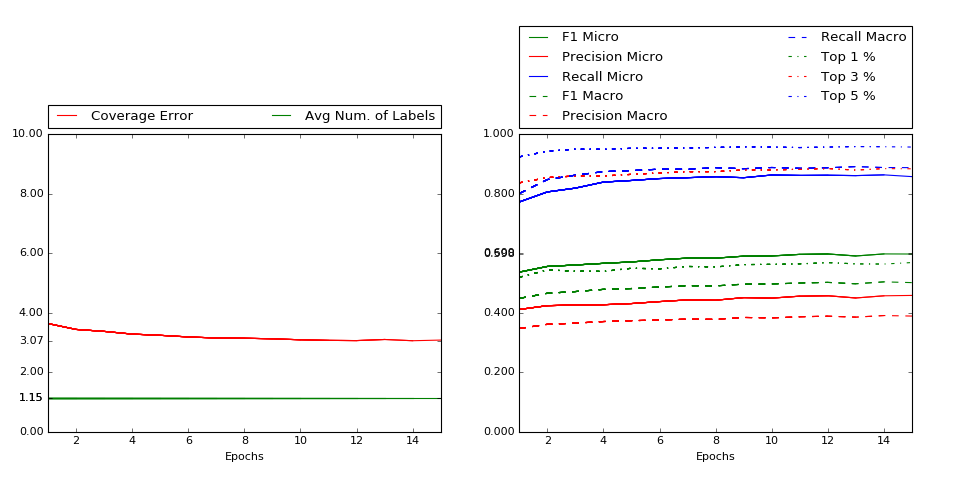

2017-01-15 02:46:22,121 : INFO : ****************** Epoch 1 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1 *******************
2017-01-15 02:46:22,123 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model
2017-01-15 02:46:26,763 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.* with mmap=None
2017-01-15 02:46:26,764 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:46:27,857 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_sea

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 1 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 02:48:26,534 : INFO : Getting Validation Embeddings
2017-01-15 02:48:26,536 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.441, Avg Labels: 1.150, 
		 Top 1: 0.542, Top 3: 0.858, Top 5: 0.941, 
		 F1 Micro: 0.565, F1 Macro: 0.476, Total Pos: 2,702,940


2017-01-15 02:48:40,937 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 0]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 1 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]


/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1, right=1
  'left=%s, right=%s') % (left, right))
2017-01-15 02:48:50,373 : INFO : ****************** Epoch 2 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2 *******************
2017-01-15 02:48:50,374 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model


** Validation Metrics: Cov Err: 3.644, Avg Labels: 1.150, 
		 Top 1: 0.520, Top 3: 0.837, Top 5: 0.925, 
		 F1 Micro: 0.537, F1 Macro: 0.449, Total Pos: 693,231


2017-01-15 02:48:58,008 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.* with mmap=None
2017-01-15 02:48:58,010 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:48:58,502 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.syn1neg.npy with mmap=None
2017-01-15 02:48:59,564 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_2/model.syn0.npy with mmap=None
2017-01-15 02:48:59,

[[0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 1 0 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 02:50:56,900 : INFO : Getting Validation Embeddings
2017-01-15 02:50:56,901 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.341, Avg Labels: 1.150, 
		 Top 1: 0.551, Top 3: 0.868, Top 5: 0.946, 
		 F1 Micro: 0.577, F1 Macro: 0.486, Total Pos: 2,686,085


2017-01-15 02:51:15,481 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 0 0 ..., 0 0 0]
 [1 0 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]]


2017-01-15 02:51:24,933 : INFO : ****************** Epoch 3 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3 *******************
2017-01-15 02:51:24,934 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model


** Validation Metrics: Cov Err: 3.447, Avg Labels: 1.150, 
		 Top 1: 0.545, Top 3: 0.855, Top 5: 0.943, 
		 F1 Micro: 0.556, F1 Macro: 0.466, Total Pos: 701,617


2017-01-15 02:51:32,612 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.* with mmap=None
2017-01-15 02:51:32,613 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:51:33,617 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn1neg.npy with mmap=None
2017-01-15 02:51:35,445 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_3/model.syn0.npy with mmap=None
2017-01-15 02:51:35,

[[0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 02:53:37,639 : INFO : Getting Validation Embeddings
2017-01-15 02:53:37,641 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.295, Avg Labels: 1.150, 
		 Top 1: 0.555, Top 3: 0.871, Top 5: 0.949, 
		 F1 Micro: 0.582, F1 Macro: 0.490, Total Pos: 2,685,335


2017-01-15 02:53:51,903 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 1 ..., 0 0 0]]


2017-01-15 02:54:01,815 : INFO : ****************** Epoch 4 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4 *******************
2017-01-15 02:54:01,817 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model


** Validation Metrics: Cov Err: 3.381, Avg Labels: 1.150, 
		 Top 1: 0.540, Top 3: 0.860, Top 5: 0.951, 
		 F1 Micro: 0.561, F1 Macro: 0.472, Total Pos: 709,202


2017-01-15 02:54:09,917 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.* with mmap=None
2017-01-15 02:54:09,918 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:54:10,154 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.syn1neg.npy with mmap=None
2017-01-15 02:54:11,240 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_4/model.syn0.npy with mmap=None
2017-01-15 02:54:11,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 02:56:10,187 : INFO : Getting Validation Embeddings
2017-01-15 02:56:10,189 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.272, Avg Labels: 1.150, 
		 Top 1: 0.558, Top 3: 0.872, Top 5: 0.950, 
		 F1 Micro: 0.585, F1 Macro: 0.493, Total Pos: 2,685,576


2017-01-15 02:56:24,357 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 02:56:34,086 : INFO : ****************** Epoch 5 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5 *******************
2017-01-15 02:56:34,087 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model


** Validation Metrics: Cov Err: 3.290, Avg Labels: 1.150, 
		 Top 1: 0.540, Top 3: 0.860, Top 5: 0.950, 
		 F1 Micro: 0.567, F1 Macro: 0.479, Total Pos: 724,930


2017-01-15 02:56:42,034 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.docvecs.* with mmap=None
2017-01-15 02:56:42,036 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:56:42,548 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.syn1neg.npy with mmap=None
2017-01-15 02:56:48,471 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_5/model.syn0.npy with mmap=None
2017-01-15 02:56:49,

[[0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 02:58:49,151 : INFO : Getting Validation Embeddings
2017-01-15 02:58:49,153 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.246, Avg Labels: 1.150, 
		 Top 1: 0.560, Top 3: 0.875, Top 5: 0.951, 
		 F1 Micro: 0.587, F1 Macro: 0.495, Total Pos: 2,685,286


2017-01-15 02:59:03,447 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 02:59:12,913 : INFO : ****************** Epoch 6 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6 *******************
2017-01-15 02:59:12,914 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model


** Validation Metrics: Cov Err: 3.249, Avg Labels: 1.150, 
		 Top 1: 0.550, Top 3: 0.866, Top 5: 0.953, 
		 F1 Micro: 0.571, F1 Macro: 0.482, Total Pos: 723,052


2017-01-15 02:59:20,557 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.* with mmap=None
2017-01-15 02:59:20,558 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 02:59:21,646 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn1neg.npy with mmap=None
2017-01-15 02:59:26,322 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/model.syn0.npy with mmap=None
2017-01-15 02:59:27,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:01:38,811 : INFO : Getting Validation Embeddings
2017-01-15 03:01:38,814 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.232, Avg Labels: 1.150, 
		 Top 1: 0.562, Top 3: 0.876, Top 5: 0.952, 
		 F1 Micro: 0.589, F1 Macro: 0.496, Total Pos: 2,682,419


2017-01-15 03:01:52,945 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 0 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:02:02,307 : INFO : ****************** Epoch 7 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7 *******************
2017-01-15 03:02:02,308 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model


** Validation Metrics: Cov Err: 3.194, Avg Labels: 1.150, 
		 Top 1: 0.548, Top 3: 0.871, Top 5: 0.954, 
		 F1 Micro: 0.579, F1 Macro: 0.487, Total Pos: 717,644


2017-01-15 03:02:05,673 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.docvecs.* with mmap=None
2017-01-15 03:02:05,675 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:02:06,248 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn1neg.npy with mmap=None
2017-01-15 03:02:13,086 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn0.npy with mmap=None
2017-01-15 03:02:13,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:04:18,983 : INFO : Getting Validation Embeddings
2017-01-15 03:04:18,984 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.219, Avg Labels: 1.150, 
		 Top 1: 0.564, Top 3: 0.878, Top 5: 0.953, 
		 F1 Micro: 0.591, F1 Macro: 0.498, Total Pos: 2,676,855


2017-01-15 03:04:33,056 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:04:42,712 : INFO : ****************** Epoch 8 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8 *******************
2017-01-15 03:04:42,713 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


** Validation Metrics: Cov Err: 3.158, Avg Labels: 1.150, 
		 Top 1: 0.556, Top 3: 0.875, Top 5: 0.954, 
		 F1 Micro: 0.584, F1 Macro: 0.492, Total Pos: 710,808


2017-01-15 03:04:51,079 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.* with mmap=None
2017-01-15 03:04:51,080 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:04:52,171 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn1neg.npy with mmap=None
2017-01-15 03:04:56,913 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn0.npy with mmap=None
2017-01-15 03:04:57,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:07:05,248 : INFO : Getting Validation Embeddings
2017-01-15 03:07:05,250 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.199, Avg Labels: 1.150, 
		 Top 1: 0.567, Top 3: 0.880, Top 5: 0.953, 
		 F1 Micro: 0.594, F1 Macro: 0.500, Total Pos: 2,665,948


2017-01-15 03:07:19,397 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:07:28,872 : INFO : ****************** Epoch 9 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9 *******************
2017-01-15 03:07:28,873 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/model


** Validation Metrics: Cov Err: 3.151, Avg Labels: 1.150, 
		 Top 1: 0.555, Top 3: 0.875, Top 5: 0.956, 
		 F1 Micro: 0.584, F1 Macro: 0.491, Total Pos: 715,278


2017-01-15 03:07:36,879 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/model.docvecs.* with mmap=None
2017-01-15 03:07:36,880 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:07:37,309 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/model.syn1neg.npy with mmap=None
2017-01-15 03:07:41,705 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/model.syn0.npy with mmap=None
2017-01-15 03:07:42,

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:09:41,606 : INFO : Getting Validation Embeddings
2017-01-15 03:09:41,608 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.191, Avg Labels: 1.150, 
		 Top 1: 0.567, Top 3: 0.881, Top 5: 0.954, 
		 F1 Micro: 0.594, F1 Macro: 0.501, Total Pos: 2,674,015


2017-01-15 03:09:55,701 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:10:05,192 : INFO : ****************** Epoch 10 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10 *******************
2017-01-15 03:10:05,193 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/model


** Validation Metrics: Cov Err: 3.132, Avg Labels: 1.150, 
		 Top 1: 0.563, Top 3: 0.881, Top 5: 0.958, 
		 F1 Micro: 0.591, F1 Macro: 0.497, Total Pos: 698,706


2017-01-15 03:10:12,693 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/model.docvecs.* with mmap=None
2017-01-15 03:10:12,695 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:10:13,336 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/model.syn1neg.npy with mmap=None
2017-01-15 03:10:14,382 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/model.syn0.npy with mmap=None
2017-01-15 03:10

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:12:26,336 : INFO : Getting Validation Embeddings
2017-01-15 03:12:26,340 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.189, Avg Labels: 1.150, 
		 Top 1: 0.568, Top 3: 0.880, Top 5: 0.955, 
		 F1 Micro: 0.594, F1 Macro: 0.501, Total Pos: 2,679,063


2017-01-15 03:12:40,607 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:12:50,016 : INFO : ****************** Epoch 11 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11 *******************
2017-01-15 03:12:50,018 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11/model


** Validation Metrics: Cov Err: 3.099, Avg Labels: 1.150, 
		 Top 1: 0.563, Top 3: 0.880, Top 5: 0.958, 
		 F1 Micro: 0.592, F1 Macro: 0.497, Total Pos: 708,816


2017-01-15 03:12:58,136 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11/model.docvecs.* with mmap=None
2017-01-15 03:12:58,137 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:12:58,381 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11/model.syn1neg.npy with mmap=None
2017-01-15 03:13:02,281 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_11/model.syn0.npy with mmap=None
2017-01-15 03:13

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:15:02,035 : INFO : Getting Validation Embeddings
2017-01-15 03:15:02,037 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.172, Avg Labels: 1.150, 
		 Top 1: 0.570, Top 3: 0.882, Top 5: 0.955, 
		 F1 Micro: 0.596, F1 Macro: 0.502, Total Pos: 2,673,534


2017-01-15 03:15:16,181 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:15:25,822 : INFO : ****************** Epoch 12 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12 *******************
2017-01-15 03:15:25,823 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model


** Validation Metrics: Cov Err: 3.079, Avg Labels: 1.150, 
		 Top 1: 0.565, Top 3: 0.883, Top 5: 0.956, 
		 F1 Micro: 0.597, F1 Macro: 0.501, Total Pos: 697,430


2017-01-15 03:15:33,909 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.docvecs.* with mmap=None
2017-01-15 03:15:33,910 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:15:35,003 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.syn1neg.npy with mmap=None
2017-01-15 03:15:39,969 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_12/model.syn0.npy with mmap=None
2017-01-15 03:15

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:19:51,198 : INFO : Getting Validation Embeddings
2017-01-15 03:19:51,201 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.162, Avg Labels: 1.150, 
		 Top 1: 0.570, Top 3: 0.883, Top 5: 0.956, 
		 F1 Micro: 0.597, F1 Macro: 0.503, Total Pos: 2,674,254


2017-01-15 03:20:05,284 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [0 1 0 ..., 0 0 0]]


2017-01-15 03:20:14,809 : INFO : ****************** Epoch 13 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13 *******************
2017-01-15 03:20:14,810 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13/model


** Validation Metrics: Cov Err: 3.072, Avg Labels: 1.150, 
		 Top 1: 0.569, Top 3: 0.885, Top 5: 0.957, 
		 F1 Micro: 0.598, F1 Macro: 0.503, Total Pos: 695,872


2017-01-15 03:20:18,163 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13/model.docvecs.* with mmap=None
2017-01-15 03:20:18,164 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:20:19,212 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13/model.syn1neg.npy with mmap=None
2017-01-15 03:20:25,358 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_13/model.syn0.npy with mmap=None
2017-01-15 03:20

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:24:28,404 : INFO : Getting Validation Embeddings
2017-01-15 03:24:28,406 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.157, Avg Labels: 1.150, 
		 Top 1: 0.572, Top 3: 0.883, Top 5: 0.956, 
		 F1 Micro: 0.598, F1 Macro: 0.504, Total Pos: 2,672,595


2017-01-15 03:24:42,603 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:24:52,314 : INFO : ****************** Epoch 14 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14 *******************
2017-01-15 03:24:52,316 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14/model


** Validation Metrics: Cov Err: 3.109, Avg Labels: 1.150, 
		 Top 1: 0.565, Top 3: 0.880, Top 5: 0.959, 
		 F1 Micro: 0.592, F1 Macro: 0.498, Total Pos: 706,344


2017-01-15 03:25:00,580 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14/model.docvecs.* with mmap=None
2017-01-15 03:25:00,581 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:25:01,670 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14/model.syn1neg.npy with mmap=None
2017-01-15 03:25:06,730 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_14/model.syn0.npy with mmap=None
2017-01-15 03:25

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:29:21,210 : INFO : Getting Validation Embeddings
2017-01-15 03:29:21,212 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.148, Avg Labels: 1.150, 
		 Top 1: 0.573, Top 3: 0.884, Top 5: 0.957, 
		 F1 Micro: 0.599, F1 Macro: 0.505, Total Pos: 2,670,232


2017-01-15 03:29:35,355 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 1 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [1 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:29:45,197 : INFO : ****************** Epoch 15 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15 *******************
2017-01-15 03:29:45,198 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15/model


** Validation Metrics: Cov Err: 3.067, Avg Labels: 1.150, 
		 Top 1: 0.564, Top 3: 0.885, Top 5: 0.959, 
		 F1 Micro: 0.598, F1 Macro: 0.505, Total Pos: 697,079


2017-01-15 03:29:53,337 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15/model.docvecs.* with mmap=None
2017-01-15 03:29:53,338 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:29:54,409 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15/model.syn1neg.npy with mmap=None
2017-01-15 03:30:00,497 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_15/model.syn0.npy with mmap=None
2017-01-15 03:30

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:33:58,463 : INFO : Getting Validation Embeddings
2017-01-15 03:33:58,465 : INFO : ===== Loading validation vectors


** Training Metrics: Cov Err: 3.135, Avg Labels: 1.150, 
		 Top 1: 0.574, Top 3: 0.886, Top 5: 0.957, 
		 F1 Micro: 0.601, F1 Macro: 0.506, Total Pos: 2,666,406


2017-01-15 03:34:17,114 : INFO : Evaluating on Validation Data


[[0 0 0 ..., 0 1 1]
 [1 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 0]
 ..., 
 [0 1 0 ..., 1 0 0]
 [1 0 0 ..., 0 1 0]
 [1 1 0 ..., 0 0 0]]


2017-01-15 03:34:26,668 : INFO : ****************** Epoch 16 --- Working on doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16 *******************
2017-01-15 03:34:26,669 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model


** Validation Metrics: Cov Err: 3.089, Avg Labels: 1.150, 
		 Top 1: 0.569, Top 3: 0.884, Top 5: 0.957, 
		 F1 Micro: 0.598, F1 Macro: 0.502, Total Pos: 690,410


2017-01-15 03:34:30,017 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.docvecs.* with mmap=None
2017-01-15 03:34:30,018 : INFO : loading doctag_syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.docvecs.doctag_syn0.npy with mmap=None
2017-01-15 03:34:31,072 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.syn1neg.npy with mmap=None
2017-01-15 03:34:35,530 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_5_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_16/model.syn0.npy with mmap=None
2017-01-15 03:34

[[0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 0 1 1]
 ..., 
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 1]]


2017-01-15 03:38:45,400 : INFO : Getting Validation Embeddings
2017-01-15 03:38:45,401 : INFO : ===== Getting validation vectors with inference
2017-01-15 03:38:45,408 : INFO : Loading new batch for index: 0


** Training Metrics: Cov Err: 3.128, Avg Labels: 1.150, 
		 Top 1: 0.575, Top 3: 0.886, Top 5: 0.958, 
		 F1 Micro: 0.602, F1 Macro: 0.507, Total Pos: 2,665,766


2017-01-15 03:38:50,649 : INFO : Finished loading new batch
2017-01-15 03:39:18,495 : INFO : Finished: 999
2017-01-15 03:39:44,064 : INFO : Finished: 1999
2017-01-15 03:40:08,437 : INFO : Finished: 2999
2017-01-15 03:40:33,004 : INFO : Finished: 3999
2017-01-15 03:40:57,387 : INFO : Finished: 4999
2017-01-15 03:41:21,068 : INFO : Finished: 5999
2017-01-15 03:41:45,713 : INFO : Finished: 6999
2017-01-15 03:42:09,850 : INFO : Finished: 7999
2017-01-15 03:42:34,223 : INFO : Finished: 8999
2017-01-15 03:42:57,078 : INFO : Finished: 9999
2017-01-15 03:42:58,322 : INFO : Loading new batch for index: 10000
2017-01-15 03:43:03,658 : INFO : Finished loading new batch
2017-01-15 03:43:28,699 : INFO : Finished: 10999
2017-01-15 03:43:53,323 : INFO : Finished: 11999
2017-01-15 03:44:18,429 : INFO : Finished: 12999
2017-01-15 03:44:43,429 : INFO : Finished: 13999
2017-01-15 03:45:10,414 : INFO : Finished: 14999
2017-01-15 03:45:35,601 : INFO : Finished: 15999
2017-01-15 03:46:00,448 : INFO : Finish

In [ ]:
%%time
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph(len(classifications) +2)
# when resuming, resume from an epoch with a previously created doc2vec model to get the learning rate right
start_from = 1
for epoch in range(start_from, DOC2VEC_MAX_EPOCHS+1):
    GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
    info("****************** Epoch {} --- Working on {} *******************".format(epoch, GLOBAL_VARS.MODEL_NAME))
    
    # if we have the model, just load it, otherwise train the previous model
    if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
        doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        info("Loaded the Doc2vec Model")
    else:
        # train the doc2vec model
        training_docs_iterator = DocumentBatchGenerator(training_preprocessed_files_prefix, 
                                                        training_preprocessed_docids_files_prefix, batch_size=10000)
        doc2vec_model.train(sentences=training_docs_iterator, report_delay=REPORT_DELAY)
        doc2vec_model.alpha -= 0.001  # decrease the learning rate
        doc2vec_model.min_alpha = doc2vec_model.alpha  # fix the learning rate, no decay
        ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
        doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
        GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
        
        # get the word2vec analogy accuracy score
        word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
        epoch_word2vec_metrics.append(word2vec_result)
        pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                                       WORD2VEC_METRICS_FILENAME), 'w'))


    info('Getting training Data')
    X, y = get_training_data(doc2vec_model, classifications)
    
    
    ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                             GLOBAL_VARS.SVM_MODEL_NAME))
    
    # try warm start and evaluate after every iter
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER)):
        info('Training Classifier')
        clf = OneVsRestClassifier(linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                                             #alpha is the 1/C parameter
                                                             alpha=SVM_REG, fit_intercept=True, n_iter=SVM_ITERATIONS,
                                                             #n_jobs=-1 means use all cpus
                                                             shuffle=True, verbose=0, n_jobs=1,
                                                             #eta0 is the learning rate when we use constant configuration
                                                             random_state=SVM_SEED, learning_rate='optimal', eta0=0.0, 
                                                             class_weight=SVM_CLASS_WEIGHTS, warm_start=False), n_jobs=1)


        # Training of a classifier
        clf.fit(X,y)
        pickle.dump(clf, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                              GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'w'))
    else:
        clf = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, CLASSIFIER), 'r'))
    
    # Training Metrics
    info('Evaluating on Training Data')
    yp = clf.predict(X)
    print yp
    training_metrics = get_metrics(y, yp, yp)
    print "** Training Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        training_metrics['coverage_error'], training_metrics['average_num_of_labels'], 
        training_metrics['top_1'], training_metrics['top_3'], training_metrics['top_5'], 
        training_metrics['f1_micro'], training_metrics['f1_macro'], training_metrics['total_positive'])
    
    epoch_training_metrics.append(training_metrics)
    
    
    # Validation Metrics
    info('Getting Validation Embeddings')
    Xv, yv = get_validation_docs_with_inference_new(doc2vec_model, doc_classification_map, classifications, 
                                                    validation_docs_list, validation_preprocessed_files_prefix,
                                                    validation_preprocessed_docids_files_prefix)
    info('Evaluating on Validation Data')
    yvp = clf.predict(Xv)
    print yvp
    validation_metrics = get_metrics(yv, yvp, yvp)
    print "** Validation Metrics: Cov Err: {:.3f}, Avg Labels: {:.3f}, \n\t\t Top 1: {:.3f}, Top 3: {:.3f}, Top 5: {:.3f}, \n\t\t F1 Micro: {:.3f}, F1 Macro: {:.3f}, Total Pos: {:,d}".format(
        validation_metrics['coverage_error'], validation_metrics['average_num_of_labels'], 
        validation_metrics['top_1'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'], validation_metrics['total_positive'])
    
    graph.add_metrics_to_graph(validation_metrics, epoch)
    
    epoch_validation_metrics.append(validation_metrics)
    
    
    # Saving the metrics
    pickle.dump(training_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, TRAINING_METRICS_FILENAME), 'w'))
    pickle.dump(validation_metrics, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                          GLOBAL_VARS.SVM_MODEL_NAME, VALIDATION_METRICS_FILENAME), 'w'))



In [37]:
GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(7)

# if we have the model, just load it, otherwise train the previous model
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))


2017-01-07 08:29:42,629 : INFO : loading Doc2Vec object from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model
2017-01-07 08:29:56,527 : INFO : loading docvecs recursively from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.docvecs.* with mmap=None
2017-01-07 08:29:56,529 : INFO : loading syn1neg from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn1neg.npy with mmap=None
2017-01-07 08:30:01,849 : INFO : loading syn0 from /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_100_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/model.syn0.npy with mmap=None
2017-01-07 08:30:02,162 : INFO : setting ignored attribu

In [51]:
%%time
ensure_disk_location_exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME))
doc2vec_model.save(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX))
GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model

# get the word2vec analogy accuracy score
%time word2vec_result = doc2vec_model.accuracy(word2vec_questions_file, restrict_vocab=None)
epoch_word2vec_metrics.append(word2vec_result)
pickle.dump(word2vec_result, open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME,
                                               WORD2VEC_METRICS_FILENAME), 'w'))


2017-01-09 08:57:31,563 : INFO : saving Doc2Vec object under /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model, separately None
2017-01-09 08:57:31,565 : INFO : storing numpy array 'syn1neg' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn1neg.npy
2017-01-09 08:57:43,811 : INFO : not storing attribute syn0norm
2017-01-09 08:57:43,813 : INFO : storing numpy array 'syn0' to /mnt/data2/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_1/model.syn0.npy
2017-01-09 08:57:44,083 : INFO : not storing attribute cum_table
2017-01-09 08:58:16,480 : INFO : precomputing L2-norms of word weight vectors
2017-01-09 08:58:34,486 : INFO : capital-common-countries: 0.3% (1/306)
2017-01-09 08:58

CPU times: user 44min 10s, sys: 2h 7min 46s, total: 2h 51min 56s
Wall time: 10min 47s
CPU times: user 44min 28s, sys: 2h 7min 55s, total: 2h 52min 23s
Wall time: 11min 31s
